In [1]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma
import random
import seaborn as sns
import pandas as pd

## Maximum Likelihood Estimation

MLE is a widely used method for estimating probabilities from data. Namely, MLE is a method of estimating the parameters of a probability distribution by maximizing a likelihood function, so that under the assumed statistical model (parameterized) the observed data is most probable.

Likelihood function: $L(\theta | D)$

You **maximize** the likelihood function such that, which $\theta$ gives you the highest probability of observing the data

$\theta$ = $argmax_\theta P(D; \theta)$
 - Select the parameter that returns the highest probability of observing the data

MLE = Maximizing $P(Y | x, \theta) = \prod_{i=1}^N(y_i | x_i, \theta)$
   - If we choose parameter $\theta$, how likely is it that each particular $x_i$ gives rise to label $y_i$

#### Approach 1 - Using Linear Algebra

In order to find the parameters $\theta$, it is kind of like reverse engineering. 

$\underbrace{\begin{pmatrix} -3 \\ -1 \\ 0 \\ 1 \\ 3 \end{pmatrix}}_{\mathbf{\vec{x}}}$ *
$\underbrace{\begin{pmatrix}  w \end{pmatrix}}_{\mathbf{\vec{\vec{w}}}}$ =
$\underbrace{\begin{pmatrix} -1.2 \\ -0.7 \\ 0.14 \\ 0.67 \\ 1.67 \end{pmatrix}}_{\mathbf{\vec{y}}}$

What parameter $w$ when multiplied by $\vec{x}$ lands on $\vec{y}$

In [2]:
# Define training set
X = np.array([-3, -1, 0, 1, 3]).reshape(-1,1) # 5x1 vector, N=5, D=1
y = np.array([-1.2, -0.7, 0.14, 0.67, 1.67]).reshape(-1,1) # 5x1 vector

In [36]:
def max_likeli_est(X, y):
    #N, D = X.shape[0], X.shape[1]
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    return theta

In [54]:
max_likeli_est(X, y)

array([[0.499]])

**Approach 2**

Example: Say you have a manufacturing plant, and at a certain step, a device is measuring the weight of the good(s). The weight measurement is subject to some error that is Gaussian distributed.

What is the most probable value of of the posterior probability density function?
- "What is the probability of the good having weight $w$, given the measurements $X$"

_Goal_: Find the weight of the good, given the data we have
- Aka, maximize the likelihood gives us $P(X | w) = \prod_i^Np(x_i | w$)
    - We can run through different values of $w$, and then choose ("arg max") the value that gives us the highest probability of observing the observed data

In [2]:
random.seed(42)
data = np.random.normal(loc=85, scale=20, size=100)
weight_grid = np.linspace(1, 200, 100)
error_grid = np.linspace(.1, 50, 100)

# Actual mean of distribution
np.mean(data)

83.45236959639641

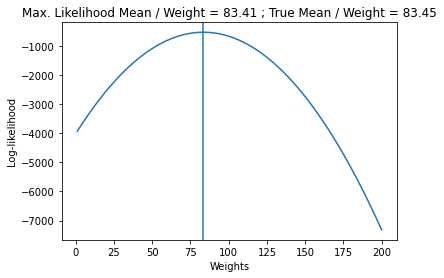

In [4]:
# Important: Assume we know the error (standard deviation = 10)
# sum over all of the log pdf's for that particular weight
likelihoods = [np.sum(norm(weight_guess, 10).logpdf(data))
               for weight_guess in weight_grid]

weight = weight_grid[np.argmax(likelihoods)]

plt.plot(weight_grid, likelihoods)
plt.xlabel('Weights')
plt.ylabel('Log-likelihood')
plt.axvline(weight)
plt.title('Max. Likelihood Mean / Weight = {} ; True Mean / Weight = {}'.format(round(weight, 2), round(np.mean(data), 2)))

# But what if we don't know the error of the measurement? We must estimate this as well
# Find the most likely weight AND error of the measurement for the good
error_grid = np.linspace(.1, 50, 100)
log_likelihoods = np.array([np.sum(norm(weight_guess, error_guess).logpdf(data))
               for weight_guess, error_guess in zip(weight_grid, error_grid)])

In [6]:
# Where the log likelihood is the highest, return the index
log_likelihood = np.argwhere(log_likelihoods == log_likelihoods.max())[0][0]
weight_grid[log_likelihood], error_grid[log_likelihood]


(83.41414141414141, 20.765656565656567)

mean = 83 and std = 20 is pretty close to the parameters of the underlying true distribution

## Maximum Posterior Estimation

If we have a prior knowledge about the distribution of the parameters $\theta$, we can multiply an additional term to the likelihood function
 - I.e., For a given prior, after observing some data $x$, how should we update the distribution of $\theta$?


**Continuation of Approach 2**

Previously, we assumed we had no prior knowledge about what the measurements of our good(s) should be. But this is obviously not true. Working in the manufacturing plant, we know the weight of our good should not be less than or greater than a certain number. 
 - We can use this information to our advantage and encode it into our problem in the form of a _prior_

In [34]:
def compute_log_likelihood(measurements, weights, errors):
    log_likelihoods = np.array([np.sum(norm(weight_guess, error_guess).logpdf(measurements))
               for weight_guess, error_guess in zip(weights, errors)])
    return log_likelihoods

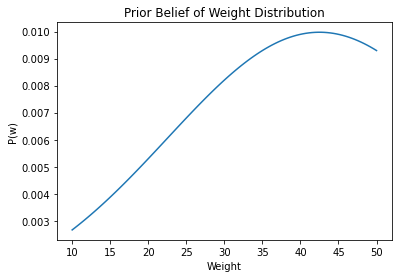

In [88]:
prior_w_grid = np.linspace(20, 100, 100)
pdf = norm.pdf(x = prior_w_grid, loc=85, scale=40)
plt.ylabel('P(w)')
plt.xlabel('Weight')
plt.title('Prior Belief of Weight Distribution')
plt.plot(x, pdf)

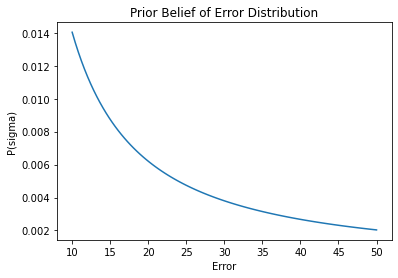

In [74]:
prior_error_grid = np.linspace(10, 50, 100)
pdf = invgamma(0.25).pdf(prior_error_grid)
plt.title('Prior Belief of Error Distribution')
plt.ylabel('P(sigma)')
plt.xlabel('Error')
plt.plot(x, pdf)

In [84]:
prior_weight = norm(50, 20).logpdf(prior_w_grid)
prior_error = invgamma(0.25).logpdf(prior_error_grid)
prior_grid = np.add.outer(prior_weight, prior_error)
#prior_grid

In [82]:
def map(measurements, weights, errors, priors):
    log_likelihood = compute_log_likelihood(measurements, weights, errors)
    log_posterior = log_likelihood + priors
    idx = np.argwhere(log_posterior == log_posterior.max())[0]
    return weights[idx][0], errors[idx][1]

In [89]:
print('Maximum Posterior Estimate: ', map(data, weight_grid, error_grid, prior_grid))

Maximum Posterior Estimate:  (75.37373737373737, 20.765656565656567)
